In [1]:
#identify best drugs for new rescuing experiments
#identify best scores, which ones are consistent?
library(dplyr)
library(ggplot2)
library(reshape2) # For data transformation
library(writexl)
library(stringr)
library(tidyr)
library(scales) 
library(ggvenn)
library(gtools)
library(tibble)


Warning message:
"package 'dplyr' was built under R version 4.2.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'writexl' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"
Warning message:
"package 'tidyr' was built under R version 4.2.3"

Attaching package: 'tidyr'


The following object is masked from 'package:reshape2':

    smiths


Warning message:
"package 'ggvenn' was built under R version 4.2.3"
Loading required package: grid

Warning message:
"package 'gtools' was built under R version 4.2.3"
Warning message:
"package 'tibble' was built under R version 4.2.3"


In [2]:
setwd("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/Drug_repurposing/results")

In [3]:
predictions<-read.csv("nemocad_RCSM_drugs_predictions.csv")


In [4]:
#now we want to foc on rescuing, but we also learn from disease by looking at inducing, so take both
# Define a helper function to perform the quantile analysis and summarize
calc_sum_ncs <- function(scores) {
  quantiles <- quantile(scores, probs = c(0.33, 0.67), na.rm = TRUE)
  compound_ncs_q_l <- quantiles[1]
  compound_ncs_q_h <- quantiles[2]
  sum_ncs <- ifelse(abs(compound_ncs_q_h) >= abs(compound_ncs_q_l),
                    compound_ncs_q_h, compound_ncs_q_l)
  return(sum_ncs)
}


In [5]:
df_summary <- predictions %>%
  group_by(cluster, cmap_name) %>%
  summarise(
    positive_count = sum(mean_col_scaled > 0, na.rm = TRUE),  
    negative_count = sum(mean_col_scaled < 0, na.rm = TRUE),  
      cell_line = paste(
      paste0(unique(cell_mfc_name), ": ",
             sapply(unique(cell_mfc_name), function(x) sum(cell_mfc_name == x))),
      collapse = "; "
    ),
    .groups = "drop"
  )
    


In [6]:
df_with_sum_ncs <- predictions %>%
  group_by(cluster, cmap_name) %>%
  summarise(
    sum_ncs = calc_sum_ncs(mean_col_scaled)
  ) %>%
  ungroup()

`summarise()` has grouped output by 'cluster'. You can override using the `.groups` argument.


In [7]:
df_merged <- df_summary %>%
  left_join(df_with_sum_ncs, by = c("cluster", "cmap_name"))

In [8]:
#check from where i can get some MOA!
df_merged$effect<-ifelse(df_merged$sum_ncs > 0 , "induce", "rescue")

In [9]:
#from the induce and rescue see top repeated MOA!
#explore beta
compound_info<-read.table("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Code/0.Data/LINCS_beta/compoundinfo_beta.txt",  header = TRUE,
  sep = "\t",
  quote = "",
  fill = TRUE
)

In [10]:
counts<-read.table("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/RNA-seq/PRPS_integration_neurons/ruviii.2000.norm_voom.txt")
rownames(counts)<-counts$Gene
counts <- counts[, -ncol(counts)]
#replace "." to "-" for colnames
colnames_counts<-colnames(counts)
colnames_counts<-gsub("\\.", "-", colnames_counts)
colnames_counts<-str_replace_all(colnames_counts, "SMARCB1_KSS_CRISPR", "SMARCB1_KSS-CRISPR")
colnames(counts)<-colnames_counts

samples_info<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Code/0.Data/RNAseq_data/samples_info.csv")
samples_info$Well_ID <- sub(".*_", "", samples_info$sample)
rownames(samples_info)<-samples_info$sample

selected_genes<-unique(compound_info$target)
selected_genes <- selected_genes[selected_genes %in% rownames(counts)]

selected_genes<-selected_genes[!selected_genes == '""']
#selected_genes
gene_means<-rowMeans(counts[selected_genes,])
qs <- quantile(gene_means, probs = c(0.33, 0.67))
mean_value <- mean(gene_means)
# Create a new vector of categories
gene_expression_category <- ifelse(
  gene_means <= 0, 
  "low",
  ifelse(gene_means <= mean_value, "below_mean", "above_mean")
)
#gene_expression_category

In [11]:
# 1️⃣ Put the named vector into a data frame
gene_expression_df <- data.frame(
  target = names(gene_expression_category),
  target_expression = gene_expression_category,
  stringsAsFactors = FALSE
)

# 2️⃣ Join by "target"
compound_info <- compound_info %>%
  left_join(gene_expression_df, by = "target")

# 3️⃣ Done!
#head(compound_info)

In [12]:
compound_info_unique <- compound_info %>%
  group_by(cmap_name) %>%
  summarize(
    moa = paste(unique(moa), collapse = "; "),
     
    target_with_expr = paste(unique(paste(target, target_expression, sep = ":")), collapse = "; "),
    .groups = "drop"
  )

In [13]:
#add target and MOA to df_merged

df_merged <- df_merged %>%
  left_join(compound_info_unique %>% select(cmap_name, moa, target_with_expr), by = "cmap_name")

In [14]:
df_merged$groups<-paste0(df_merged$cluster, "_", df_merged$effect)

pdf 
  2

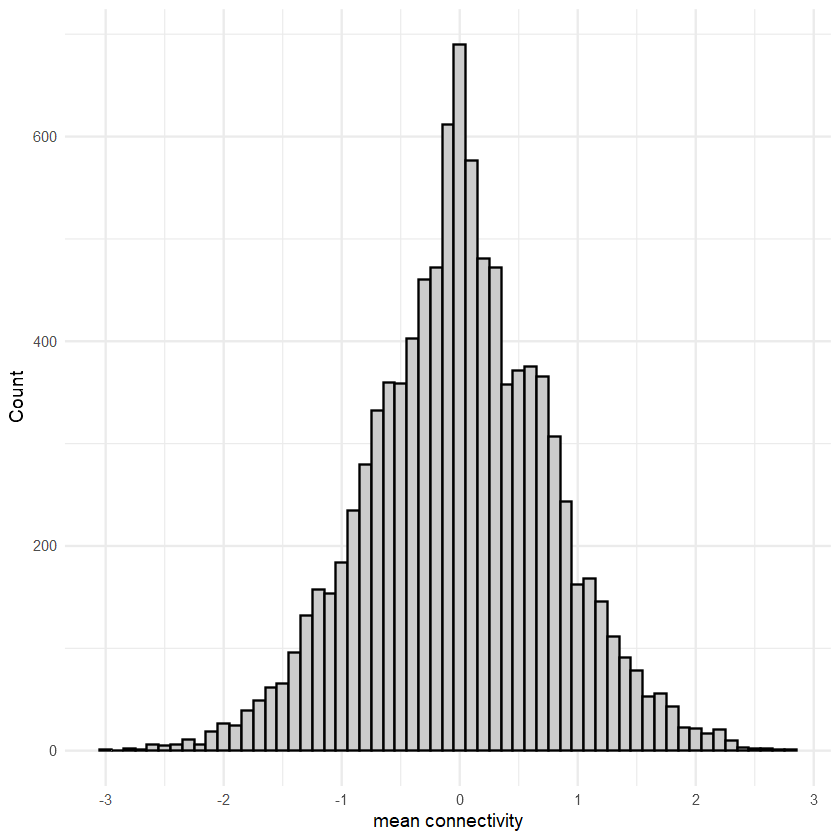

In [17]:


# Basic histogram with mean_col_scaled
p <- ggplot(predictions, aes(x = mean_col_scaled)) +
  geom_histogram(binwidth = 0.1, fill = "#CCCCCC", color = "black") +
#  geom_vline(xintercept = -1, linetype = "dashed", color = "black", size = 1) +
#  geom_vline(xintercept = 1, linetype = "dashed", color = "black", size = 1) +
  labs(
    #title = "Distribution of mean_col_scaled",
    x = "mean connectivity",
    y = "Count"
  ) +
  theme_minimal()

print(p)

ggsave("mean_col_scaled.pdf",bg = "transparent",
                  width = 3,   # inches
                  height = 3,
                   plot=p# inches
)

In [15]:
df_merged_list<-split(df_merged,df_merged$groups)
df_merged_list<-lapply(df_merged_list, function(df) {df[order(-abs(df$sum_ncs)),]
                                                  })

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


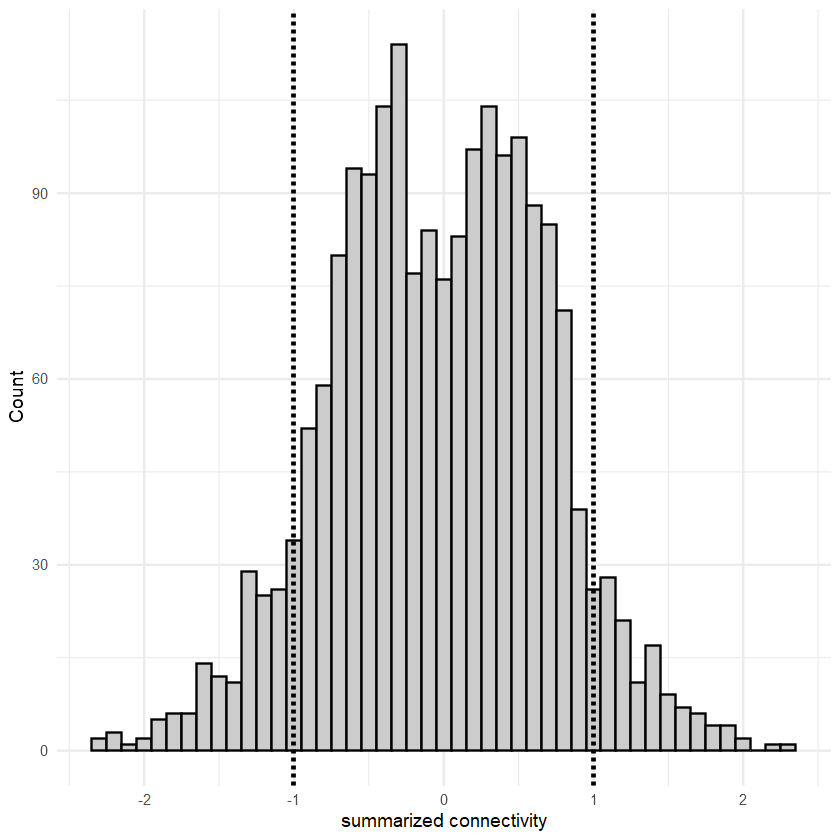

In [19]:
# Basic histogram with mean_col_scaled
p <- ggplot(df_merged, aes(x = sum_ncs)) +
  geom_histogram(binwidth = 0.1, fill = "#CCCCCC", color = "black") +
  geom_vline(xintercept = -1, linetype = "dashed", color = "black", size = 1) +
  geom_vline(xintercept = 1, linetype = "dashed", color = "black", size = 1) +
  labs(
    #title = "Distribution of mean_col_scaled",
    x = "summarized connectivity",
    y = "Count"
  ) +
  theme_minimal()

print(p)


ggsave("sum_ncs.pdf",bg = "transparent",
                  width = 3,   # inches
                  height = 3,
                   plot=p# inches
)

In [20]:

# Write to a single Excel file:
write_xlsx(df_merged_list, path = "Averaged_nemocad_connectivity_results_PLSR.xlsx")

In [16]:
df_merged_filtered<-df_merged[abs(df_merged$sum_ncs) >= 1,]

In [17]:
table(df_merged_filtered$groups)


clust1_induce clust1_rescue clust2_induce clust2_rescue clust3_induce 
           50            75            10            29            41 
clust3_rescue clust4_induce clust4_rescue 
           24            20            24 

In [18]:
# 1️⃣ Split the MOA column, trim spaces, handle unknowns
df_long <- df_merged_filtered %>%
  separate_rows(moa, sep = ";") %>%          # Split on ;
  mutate(
    moa = str_trim(moa),
    moa = str_replace_all(moa, '^""$', "Unknown"),
    moa = ifelse(is.na(moa) | moa == "" | moa == " ", "Unknown", moa)

  )

In [19]:
moa_order <- df_long %>%
  group_by(groups, moa) %>%
  summarise(max_abs_sum_ncs = max(abs(sum_ncs), na.rm = TRUE), .groups = "drop")

In [20]:
moa_counts <- df_long %>%
  group_by(groups, moa) %>%
  summarise(n = n(), .groups = "drop")

In [21]:
moa_counts <- moa_counts %>%
  left_join(moa_order, by = c("groups", "moa"))


In [22]:
for (group in levels(factor(moa_counts$groups))){
    df<-moa_counts[moa_counts$groups == group, ]
    n_moa<-length(unique(df$moa))
    est <- max(n_moa * 0.15, 3) 
    p<- ggplot(df, aes(x = n, y =  reorder(moa, max_abs_sum_ncs))) +
    geom_bar(stat = "identity") +
    
    scale_x_continuous(
      breaks = pretty_breaks(n = 3),  # 5 nice integer breaks
      expand = c(0, 0)
    ) +
    
    labs(
    x = "Count",
    y = "MOA"#,
   # title = "MOA counts per group"
  )



    ggsave(paste0("moa_",group,".pdf"),bg = "transparent",
                  width = 6,   # inches
                  height = est,
                   plot=p# inches
)
    
}



In [28]:
n_colors=c("1"="#B7A4D1","2"="#008B45","3"="#66FFFF","4"="#F1C6A7","5"="#8896A0","6"="#D6C45C","7"="#3B5A80",
          "8"="#F1C6A7", "9"="#0000FF","10"="#66FFFF","11"="#FF9933","12"="#CCCC00") #washed out

In [29]:
library(ggVennDiagram)



Attaching package: 'ggVennDiagram'


The following object is masked from 'package:tidyr':

    unite




In [30]:
induce<-df_merged_list[c(1,3,5,7)]
rescue<-df_merged_list[c(2,4,6,8)]
induce_drugs<-lapply(induce, function (df) df[["cmap_name"]])
rescue_drugs<-lapply(rescue, function (df) df[["cmap_name"]])

p<-ggvenn(
  induce_drugs,
  fill_color =  c("#C1CDCD", "#6E8B3D", "#8B7B8B", "#F1C6A7"),  # circle fill colors
  stroke_size = 0.5,
  set_name_size = 0,
  text_size = 4.5
)

# tiff("overlaping_induce_drugs.tiff", res = 400, units = "in", width =5, height = 6)
#     print(p)
# dev.off()
ggsave("overlaping_induce_drugs.pdf", bg = "transparent",
                  width = 5,   # inches
                  height = 6,
                   plot=p# inches
)

                

In [31]:
induce<-df_merged_list[c(1,3,5,7)]
rescue<-df_merged_list[c(2,4,6,8)]
induce_drugs<-lapply(induce, function (df) df[["cmap_name"]])
rescue_drugs<-lapply(rescue, function (df) df[["cmap_name"]])

p<-ggvenn(
  rescue_drugs,
  fill_color =  c("#C1CDCD", "#6E8B3D", "#8B7B8B", "#F1C6A7"),  # circle fill colors
  stroke_size = 0.5,
  set_name_size = 0,
  text_size = 4.5
)

# tiff("overlaping_rescue_drugs_top6.tiff", res = 400, units = "in", width =5, height = 6)
#     print(p)
# dev.off()
ggsave("overlaping_rescue_drugs.pdf", bg = "transparent",
                  width = 5,   # inches
                  height = 6,
                   plot=p# inches
)

In [32]:
# Keep each combination group as a list element
comb_list <- lapply(2:4, function(k) {
  combinations(n = length(rescue_drugs), r = k, v = names(rescue_drugs))
})

# If you want all combinations in one long list of character vectors:
comb_vector_list <- unlist(
  lapply(comb_list, function(mat) split(mat, seq(nrow(mat)))),
  recursive = FALSE
)
    # Store intersections in a named list
intersections <- list()

for (i in 1:length(comb_vector_list)) {
  combo <- comb_vector_list[[i]]
  combo_name <- paste(combo, collapse = "_&_")
  intersections[[combo_name]] <- Reduce(intersect, rescue_drugs[combo])
}

# Example: View 2-way overlap between clust1 and clust2
# Convert to tibble and unnest the list column
intersections_df <- enframe(intersections, name = "combination", value = "drug") %>%
  unnest(cols = drug)

# Write to CSV
write.csv(intersections_df, "drug_rescue_intersections.csv", row.names = FALSE)

In [33]:
# 1️⃣ Split the MOA column, trim spaces, handle unknowns
df_long <- df_merged_filtered %>%
  separate_rows(moa, sep = ";") %>%          # Split on ;
  mutate(
    moa = str_trim(moa),
    moa = str_replace_all(moa, '^""$', "Unknown"),
    moa = ifelse(is.na(moa) | moa == "" | moa == " ", "Unknown", moa)

  )

In [34]:
df_merged_list<-split(df_long,df_long$groups)
df_merged_list<-lapply(df_merged_list, function(df) {df[order(-abs(df$sum_ncs)),]
                                                  })
df_merged_list<-lapply(df_merged_list, function(df) {df[order(-abs(df$sum_ncs)),]})
induce<-df_merged_list[c(1,3,5,7)]
rescue<-df_merged_list[c(2,4,6,8)]
induce_drugs<-lapply(induce, function (df) df[["moa"]])
rescue_drugs<-lapply(rescue, function (df) df[["moa"]])
rescue_drugs <- lapply(rescue_drugs, function(x) x[x != "Unknown"])
induce_drugs <- lapply(induce_drugs, function(x) x[x != "Unknown"])

names(rescue_drugs) <- c("clust1", "clust2", "clust3", "clust4")
names(induce_drugs) <- c("clust1", "clust2", "clust3", "clust4")           

In [35]:

p<-ggvenn(
  induce_drugs,
  fill_color =  c("#C1CDCD", "#6E8B3D", "#8B7B8B", "#F1C6A7"),  # circle fill colors
  stroke_size = 0.5,
  set_name_size = 0,
  text_size = 4.5
)

# tiff("overlaping_induce_moa_top6.tiff", res = 400, units = "in", width =5, height = 6)
#     print(p)
# dev.off()
ggsave("overlaping_induce_moa_drugs.pdf", bg = "transparent",
                  width = 5,   # inches
                  height = 6,
                   plot=p# inches
)

In [36]:
p<-ggvenn(
rescue_drugs,
  fill_color =  c("#C1CDCD", "#6E8B3D", "#8B7B8B", "#F1C6A7"),  # circle fill colors
  stroke_size = 0.5,
  set_name_size = 0,
  text_size = 4.5
)

# tiff("overlaping_rescue_moa_top6.tiff", res = 400, units = "in", width =5, height = 6)
#     print(p)
# dev.off()
ggsave("overlaping_rescue_moa_drugs.pdf", bg = "transparent",
                  width = 5,   # inches
                  height = 6,
                   plot=p# inches
)

In [37]:
# Keep each combination group as a list element
comb_list <- lapply(2:4, function(k) {
  combinations(n = length(rescue_drugs), r = k, v = names(rescue_drugs))
})

# If you want all combinations in one long list of character vectors:
comb_vector_list <- unlist(
  lapply(comb_list, function(mat) split(mat, seq(nrow(mat)))),
  recursive = FALSE
)
    # Store intersections in a named list
intersections <- list()

for (i in 1:length(comb_vector_list)) {
  combo <- comb_vector_list[[i]]
  combo_name <- paste(combo, collapse = "_&_")
  intersections[[combo_name]] <- Reduce(intersect, rescue_drugs[combo])
}

# Example: View 2-way overlap between clust1 and clust2
# Convert to tibble and unnest the list column
intersections_df <- enframe(intersections, name = "combination", value = "drug") %>%
  unnest(cols = drug)

# Write to CSV
write.csv(intersections_df, "moa_rescue_intersections.csv", row.names = FALSE)

In [38]:
# Keep each combination group as a list element
comb_list <- lapply(2:4, function(k) {
  combinations(n = length(induce_drugs), r = k, v = names(induce_drugs))
})

# If you want all combinations in one long list of character vectors:
comb_vector_list <- unlist(
  lapply(comb_list, function(mat) split(mat, seq(nrow(mat)))),
  recursive = FALSE
)
    # Store intersections in a named list
intersections <- list()

for (i in 1:length(comb_vector_list)) {
  combo <- comb_vector_list[[i]]
  combo_name <- paste(combo, collapse = "_&_")
  intersections[[combo_name]] <- Reduce(intersect, induce_drugs[combo])
}

# Example: View 2-way overlap between clust1 and clust2
# Convert to tibble and unnest the list column
intersections_df <- enframe(intersections, name = "combination", value = "drug") %>%
  unnest(cols = drug)

# Write to CSV
write.csv(intersections_df, "moa_induce_intersections.csv", row.names = FALSE)